## Подключение к API интернет-магазина ebay.com(US), загрузка необходимых данных и первоначальный базовый анализ выгруженных данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ebaysdk.finding import Connection as Finding

### 1. Подключение к API интернет-магазина ebay.com(US)

Создадим функцию запроса к API ebay и вывод в словаре dict

In [196]:
def get_results(request):
    api = Finding(appid='MyAppID', 
                  siteid="EBAY-US",
                  domain='svcs.sandbox.ebay.com')
    response = api.execute('findItemsByKeywords', request)
    return response.dict()    

### 2. Получение данных

Подготовка запроса на примере ключевого слова phone

In [201]:
request = {
        'keywords': 'phone', 
        #'categoryId': '178893',
            'paginationInput': {
            'entriesPerPage': 100}
        #'itemFilter': {},
        #'sortOrder': 'StartTimeNewest'
}

In [202]:
# Делаем запрос
results = get_results(request)

# Результат выводится на нескольких страницах
total_pages = int(results.get('paginationOutput').get('totalPages')) # количество страниц

# 'item' - вывод одной страницы. Соберем все страницы в переменной items_list
items_list = results['searchResult']['item']
i = 2 
while(i <= total_pages):
    request['paginationInput'] = {'entriesPerPage': 100, 'pageNumber': i}        
    results = get_results(request)
    items_list.extend(results['searchResult']['item'])
    i += 1
    
# Переведем наш результат в pandas DataFrame
df = pd.DataFrame(columns=['Номер продукта', 'Наименование', 'Категория', 'Цена'])

for item in items_list:
        row = {
            'Номер продукта': item.get('itemId'),
            'Наименование': item.get('title'),
            'Категория' : item.get('primaryCategory').get('categoryName'),
            'Цена': item.get('sellingStatus').get('currentPrice').get('value')
        }
        df_next = pd.DataFrame([row])
        df = pd.concat([df, df_next],axis=0, ignore_index=True)          

### 3. Первоначальный базовый анализ выгруженных данных

#### 3.1 Проведем начальный анализ полученных данных в датафрейме df

In [206]:
df.head()

,Номер продукта,Наименование,Категория,Цена
0,110552870414,"Samsung, SM-J320A Galaxy J3 Unlocked White",Cell Phones & Smartphones,69.0
1,110552870602,Samsung VZW-SCHI545KPP Galaxy S4 Verizon Prepa...,Cell Phones & Smartphones,149.0
2,110552888490,SONY Alpha a5100 24.3MP Digital Camera - Black...,Cell Phones & Smartphones,66.33
3,110552828847,Apple iPhone 7 - 32GB - Black (Unlocked) A1778...,Cell Phones & Smartphones,69.99
4,110552871302,Galaxy S5ng G900T-S5 Galaxy S5 Smartphone,Cell Phones & Smartphones,349.0


In [343]:
# Изменим для столбца 'Цена' тип данных на float64 
df['Цена'] = df['Цена'].astype('float64')
# Найдем в каждой категории цены мин и макс. 
display(df.groupby('Категория')['Цена'].agg(['min', 'max']))

,min,max
Категория,,
Business Phone Sets & Handsets,67.80,81.22
"Cases, Covers & Skins",60.00,60.00
Cell Phones & Smartphones,6.99,700.00
Fountain,699.00,699.00
Mounts & Holders,3.59,18.04
Other Men's Vintage Clothing,39.99,39.99
"Other Motorcycle Maintenance, Stands & Towing",57.63,57.63
Signal Boosters,32.76,32.76


**Вывод:** Выгружены данные делятся по 8 категориям товаров. Посчитаны минимальние и максимальные цены по каждой категории

#### 3.1 Найдем в каких категориях самые высокие средние цены

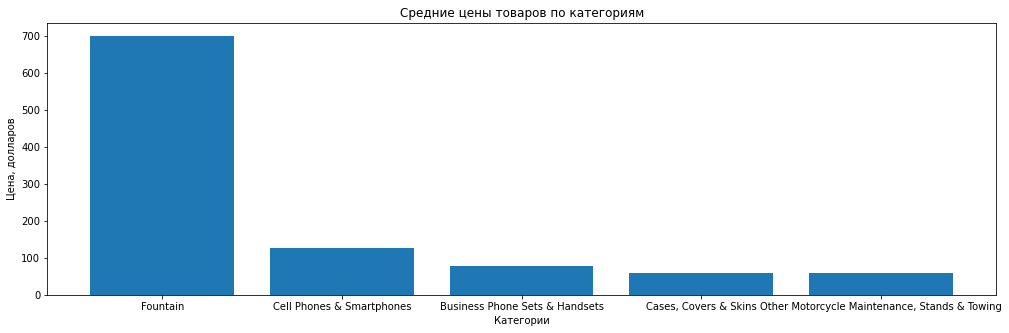

In [303]:
# Создадим сводную таблицу Средних цен товаров по категориям
df_categories = df.groupby('Категория')['Цена'].agg(['mean']).sort_values(by='mean', ascending=False)
# Изобразим графически полученные результаты
plt.figure(figsize=(17,5))
plt.title('Средние цены товаров по категориям')
plt.xlabel('Категории')
plt.ylabel('Цена, долларов')
plt.bar(df_categories.index[:5],df_categories['mean'][:5])
plt.show()

**Вывод:** Самые высокие средние цены в категории 'Fountain', на уровне 700 долларов за товар. По остальным категориям средние цены не превышают 200 долларов.

#### 3.2 Определим по названию производителей мобильных телефонов, выявим ценовые сегменты самых популярных брендов имеющихся в продаже на данный момент

,Наименование,Цена,Производитель
0,LG Optimus Phone FreedomPOP LG-LS720VSLRB F3 L...,60.00,LG
1,SONY Alpha a5100 24.3MP Digital Camera - Black...,66.33,SONY
2,"Samsung, SM-J320A Galaxy J3 Unlocked White",69.00,Samsung
3,Apple iPhone 7 - 32GB - Black (Unlocked) A1778...,69.99,Apple
4,Apple iPhones N,100.00,Apple
5,LG G7 ThinQ G710VMP 64GB 4GB RAM 6.1‘’ Unlocke...,142.00,LG
6,Samsung VZW-SCHI545KPP Galaxy S4 Verizon Prepa...,149.00,Samsung
7,Samsung SCH-I605 Galaxy Note II 16GB Titanium ...,700.00,Samsung


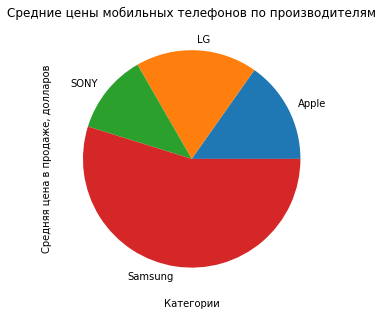

In [340]:
# Выведем модели мобильный телефонов известных брендов
df_mobile_phones = df[(df['Категория']=='Cell Phones & Smartphones') & # выбираем категорию Мобильники
   (df['Наименование'].str.contains('Apple|Samsung|LG|SONY',  regex=True))][ # Выбираем известные марки
    ['Наименование', 'Цена']].drop_duplicates( # убираем дупликаты 
   ).sort_values(by='Цена').reset_index(drop=True) # сбрасываем индексы и сортируем по цене

# Добавим столбец с производителем, наименование которого возьмем как первое слово из наименования товара
df_mobile_phones['Производитель'] = df_mobile_phones['Наименование'].apply(lambda x: x.replace(',', ' ').split()[0])
display(df_mobile_phones)

# Изобразим графически полученные результаты
plt.figure(figsize=(17,5))
plt.title('Средние цены мобильных телефонов по производителям')
plt.xlabel('Категории')
plt.ylabel('Средняя цена в продаже, долларов')
plt.pie(df_mobile_phones.groupby('Производитель').mean()['Цена'],
        labels=df_mobile_phones.groupby('Производитель').mean().index)
plt.show()

**Вывод:** согласно полученным данным имеются мобильные телефоны брендов LG, Samsung, Apple и Sony в ценовой категории 60-700 долларов. В премиум-сегменте представлен телефон Samsums Galaxy Note II, остальные телефоны с средней или бюджетной ценовой категории.

**Общий вывод**: <br>
1) Проведено подключение к API интернет-магазина ebay.com(US), <br>
<br>
2) Загружены данные по наличию телефонов в продаже согласно запроса, <br>
<br>
3) Первоначальный базовый анализ выгруженных данных показал:<br>
 - Выгружены данные делятся по 8 категориям товаров. 
 - Посчитаны минимальние, максимальные и средние цены по каждой категории.
 - Самые высокие средние цены в категории 'Fountain', на уровне 700 долларов за товар. По остальным категориям средние цены не превышают 200 долларов. Эти данные представлены графически.
 - Основными брендами мобильных телефонов являются: LG, Samsung, Apple и Sony в ценовых категориях 60-700 долларов. В премиум-сегменте представлен телефон Samsums Galaxy Note II, остальные телефоны в средней или бюджетной ценовой категории.